In [148]:
import numpy as np
import math

import pickle
pickle_in = open("data.pickle", "rb")
train = pickle.load(pickle_in)
valid = pickle.load(pickle_in)
test = pickle.load(pickle_in)
print(len(train))
print(len(valid))
print(len(test))
traind = np.zeros(shape=(len(train),14), dtype = np.int64)
labeld = []
for i in range(len(train)):
    labeld.append(train[i][0])
    traind[i] = train[i][1:] 
    
testd = np.zeros(shape=(len(test),14), dtype = np.int64)
labeltest = []
for i in range(len(test)):
    labeltest.append(test[i][0])
    testd[i] = test[i][1:] 
    
validd = np.zeros(shape=(len(valid),14), dtype = np.int64)
labelvalid = []
for i in range(len(valid)):
    labelvalid.append(valid[i][0])
    validd[i] = valid[i][1:] 


27000
3000
7000


In [173]:
#split_attr is the attribute that is CHOSEN by THAT node:
#so meaningless for leaves
#chd is a list of node objects [list of children]
class Node(object):
    leaf = False
    result_leaf = -1
    
    def __init__(self, split_attr, indices, chd, count):
        self.split_attr = split_attr
        self.indices = indices #list of input indices
        self.chd = chd
        self.testindices = [] #list of test/valid indices 
        #self.isLeaf()
        self.ID = count
        self.size = 0
        #count +=1
    def isLeaf(self):
        if (self.chd == None):
            self.leaf = True
            return True
        for i in range(len(self.chd)):
            if (self.chd[i]!=None):
                return False    
        self.leaf = True
        return True 
    def result(self):
        global Plurality_value
        result_leaf=Plurality_value(self.indices)
        return self.result_leaf


#features available to be split-on
attr_avail = [i for i in range(14)]
init = [i for i in range(len(traind))]

lol = [[]]*14
lol[0] = [0,1]#age
lol[1]=[i for i in range(8)]#wc
lol[2] = [0,1]#fnlwgt
lol[3]=[i for i in range(16)]#edu
lol[4] = [0,1]#edun
lol[5]=[i for i in range(7)]#mar
lol[6]=[i for i in range(14)]#occ
lol[7]=[i for i in range(6)]#rel
lol[8]=[i for i in range(5)]#race
lol[9]=[0,1]#sex
lol[10] = [0,1]#capg
lol[11] = [0,1]#capl
lol[12] = [0,1]#hpw
lol[13]=[i for i in range(41)]#nc

#rangeofval = listoflist of attribute values
def Value_attr(best_attr):
    global lol
    return lol[best_attr]

#S: list of indices of data[] at this node

def Plurality_value(S):
    global labeld
    if (len(S)==0):
        return 1
    pos = 0
    neg = 0
    for i in S:
        if (labeld[i]==1):
            pos+=1
        else: 
            neg+=1
    if (pos>=neg):
        return 1
    else:
        return 0

count_nodes = 0

acc_map = {} #countnodes to training acc
plotroot = Node

def GrowTree(S, Sparent, data, label, attr_avail):
    global count_nodes
    #global plotroot     
    # 1. If size is 0, result is plurality value of parent examples
    if (len(S)==0):
        result = Plurality_value(Sparent)
        n = Node(-1, None, None, count_nodes)
        n.leaf = True
        n.result_leaf = result 
        count_nodes+=1
        n.size = 0
        return n
    
    # 2. Is the set of examples pure?
    purity = 1
    for i in range(len(S)-1):
        if (label[S[i]]!=label[S[i+1]]):
            purity = 0
            break
    if (purity==1):
        n = Node(-1, S, None, count_nodes)
        n.result_leaf = label[S[0]]
        n.leaf = True
        count_nodes+=1
        n.size = 0
        return n
    else:
        #3. if all attributes along this path are exhausted return p.v. (current set)
        if (len(attr_avail)==0):
            result = Plurality_value(S)
            n = Node(-1, S, None, count_nodes)
            n.result_leaf = result 
            n.leaf=True
            count_nodes+=1
            n.size = 0
            return n
        bestattr = choosebestattr(S, data, label, attr_avail)
        print("bestattr:", bestattr)
        val_bestattr = Value_attr(bestattr)
        attr_avail.remove(bestattr) #remove from list of avl attr
        n = Node(bestattr, S, None, count_nodes)
        count_nodes+=1
        n.result_leaf = Plurality_value(S)
        if (count_nodes==1):
            plotroot = n

        list_chd = [] #list of children nodes for this node
        splits = [[]]*len(val_bestattr)
        for i in range (len(splits)):
            splits[i] = []
        for i in S:
            #print(data[i][bestattr])
            splits[data[i][bestattr]].append(i)
        #print("len splits:0", len(splits[0]))
        #print("len splits:1", len(splits[1]))
        
        instancelist = [ Node(-1, splits[i], None, None) for i in range(len(splits))]
        n.chd = instancelist
        for i in range(len(splits)):
            instancelist[i].result_leaf=Plurality_value(splits[i])
        n.chd = instancelist
#         if (count_nodes%3==0):
#             acc_map[count_nodes]=check(testd, labeltest, plotroot)
            #print("splits:",i, " size", len(splits[i]))
        for i in range(len(splits)):
            print("splits:",i, " size", len(splits[i]))
            attr_chd = list(attr_avail)
            instancelist[i]=GrowTree(splits[i],S, data, label, attr_chd)
            list_chd.append(instancelist[i])
        n.chd = list_chd
        size = 0
        for i in list_chd:
            size+=(i.size+1)
        n.size = size
        n.result()
    return n

def choosebestattr(S, data, label, attr_avail):
    global lol
    TE ={} 
    #store total entropy of splits - for each possible attribute; return min
    print("attr_avail size:", len(attr_avail), "S size:", len(S))
    for attr in attr_avail:
        split=[[]]*len(lol[attr])
        E = [[]]*len(lol[attr])
        for i in range(len(split)):
            split[i]=[]
            E[i]=[]
        for j in S:
            split[data[j][attr]].append(j)
        sumsplit=0
        for k in range (len(split)):
            #print("len split:",k," ",len(split[k]))
            sumsplit+=len(split[k])
        assert(len(S)==sumsplit)
        #print("len split in choosebestattr:", len(split))
        for i in range(len(split)):
                if (len(split[i])==0):
                    E[i]=0
                    continue
                count_p=0 #1==rich
                count_n=0 #0==poor
                for j in split[i]:
                    if (label[j]==1):
                        count_p+=1
                    else:
                        count_n+=1
                p = (count_p)/(count_p+count_n)
                #print("p:", p)
                if (p==0 or p==1):
                    E[i]=0
                else:
                    E[i]=-1*(p*math.log(p, 2)+(1.0-p)*math.log((1.0-p), 2))
                E[i]*=(count_p+count_n)/(len(S))
                #print(E[i])
        #print("attr", attr)
        su = 0
        for i in range(len(split)):
            su+=E[i]
        TE[attr]=su
    print("about to return:", TE)
    print(min(TE, key=TE.get))
    return min(TE, key=TE.get)
   
#testing:
#tdata is an integer array having 14 attributes [0...13]
def Test(tdata, index, node, valid_true):    
    if (valid_true==1):
        node.testindices.append(index)
    if (node.isLeaf()==True):
        #print("leaf encountered")
        #print("node testindices:", node.testindices)
        return node.result_leaf
    #print("listchd encountered")
    listchd = node.chd
    return Test(tdata, index, listchd[tdata[node.split_attr]], valid_true)

def check(d, l, r, valid_true):
    global root
    if (valid_true ==1):
        clean_testindices(root)
    result = [[]]*len(d)
    correct=0
    wrong = 0
    for i in range(len(d)):
        result[i]=Test(d[i], i, r, valid_true)
        if (result[i]==l[i]):
                correct+=1
        else:
                wrong+=1
    print("accuracy:", correct, wrong, correct/(wrong+correct)*100)
    return result,correct, wrong, (correct/(wrong+correct)*100)

def clean_testindices(r):
        r.testindices=[]
        if (r.isLeaf()):
            return
        for i in range(len(r.chd)):
            clean_testindices(r.chd[i])
  

In [174]:
def computeaccuracy(node, correct, wrong):  #during prune traversal -- correct and wrong are local variables
    global actual_labels
    global labelvalid
    result_node = node.result()
    for i in node.testindices: #index of inlet to node validation set
        if (actual_labels[i]!=result_node):
            if (labelvalid[i]==result_node):
                correct+=1
                wrong-=1
            else:
                correct-=1
                wrong+=1
    #print("local correct, wrong:", correct, " ",wrong)
    return (correct/(correct+wrong))*100
                

def numberkids(n):
    counter = 0 #excluding self
    if (n.isLeaf()):
        return 0
    for i in n.chd:
        counter+=(numberkids(i)+1)
    return counter
    
    
#Post construction pruning:
track = {} #(number of nodes, val accuracy)
track_test ={} # " test
track_train = {} # " train

def PostPrune(r, data, pruneacc):
    global correct 
    global wrong 
    global actual_labels
    global labelvalid
    global track 
    global count_nodes #total number of nodes
    tnodes = count_nodes
    while (True):
        print("c,w:",correct, wrong)
        acctemp = {}
        Prunetravel(r, acctemp)
        #print("acctemp size:", len(acctemp))
        node=max(acctemp, key=acctemp.get)
        if (pruneacc[-1]>acctemp[node]):
            break
        pruneacc.append(acctemp[node])
        nkids = numberkids(node)
        node.chd = None
        node.isLeaf()
        result_node = node.result()
        for i in node.testindices: #index of inlet to node validation set
            if (actual_labels[i]!=result_node):
                if (labelvalid[i]==result_node):
                    correct+=1
                    wrong-=1
                else:
                    correct-=1
                    wrong+=1
        for i in node.testindices:
             actual_labels[i]=node.result_leaf
        print(tnodes-numberkids(node), pruneacc[-1])
        track[tnodes-nkids]=pruneacc[-1]
        _,_,_,track_test[tnodes-nkids] = check(testd, labeltest, root, 0)
        _,_,_,track_train[tnodes-nkids] = check(traind, labeld, root, 0)
        tnodes=tnodes-nkids
    
    
size=[]                
def Prunetravel(r, acc):
    if (r.isLeaf()):
        return
    global correct 
    global wrong 
    global size
    #print("before entering computeaccuracy:", correct, " ", wrong)
    acc[r] = computeaccuracy(r, correct, wrong)
    size.append(len(acc))
    #_,_,_,acc[r]=check(validd, labelvalid, root, 0)
    #print("after entering computeaccuracy:", correct, " ", wrong)
    for i in r.chd:
        Prunetravel(i, acc)
    

In [175]:
root = GrowTree(init, init, traind, labeld,attr_avail)

attr_avail size: 14 S size: 27000
about to return: {0: 0.7567428328499834, 1: 0.7908106619845612, 2: 0.8082574661564588, 3: 0.7144590514618083, 4: 0.7667116548934076, 5: 0.6499751738674563, 6: 0.7150118363769195, 7: 0.640559092359263, 8: 0.8001256228943249, 9: 0.7707728010471883, 10: 0.8083890195918375, 11: 0.8083890195918375, 12: 0.7796382352656703, 13: 0.7988426511183495}
7
bestattr: 7
splits: 0  size 1257
attr_avail size: 13 S size: 1257
about to return: {0: 0.9874142722588535, 1: 0.9816919497757867, 2: 0.9999766643479647, 3: 0.8687109575875083, 4: 0.9263863250555715, 5: 0.9999342661306849, 6: 0.8713607142327014, 8: 0.9897023094413445, 9: 0.9992026274573844, 10: 0.9999995434650466, 11: 0.9999995434650466, 12: 0.9986635208496886, 13: 0.9653858581745856}
3
bestattr: 3
splits: 0  size 235
attr_avail size: 12 S size: 235
about to return: {0: 0.8629665833506666, 1: 0.8668691282274275, 2: 0.8727123937888641, 4: 0.8733478694531565, 5: 0.8690581082101613, 6: 0.7979011591464714, 8: 0.8585073

splits: 1  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 6
attr_avail size: 6 S size: 6
about to return: {4: 0.6500224216483541, 5: 0.6500224216483541, 8: 0.6500224216483541, 9: 0.6500224216483541, 10: 0.6500224216483541, 11: 0.6500224216483541}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 6
attr_avail size: 5 S size: 6
about to return: {5: 0.6500224216483541, 8: 0.6500224216483541, 9: 0.6500224216483541, 10: 0.6500224216483541, 11: 0.6500224216483541}
5
bestattr: 5
splits: 0  size 6
attr_avail size: 4 S size: 6
about to return: {8: 0.6500224216483541, 9: 0.6500224216483541, 10: 0.6500224216483541, 11: 0.6500224216483541}
8
bestattr: 8
splits: 0  size 6
attr_avail size: 3 S size: 6
about to return: {9: 0.6500224216483541, 10: 0.6500224216483541, 11: 0.6500224216483541}
9
bestattr: 9
splits: 0  size 6
attr_avail size: 2 S size: 6

1
bestattr: 1
splits: 0  size 14
attr_avail size: 8 S size: 14
about to return: {0: 0.5891892911062069, 2: 0.5813546776726874, 4: 0.5916727785823274, 5: 0.5916727785823274, 9: 0.5916727785823274, 10: 0.5916727785823274, 11: 0.5916727785823274, 12: 0.4315602842833155}
12
bestattr: 12
splits: 0  size 7
splits: 1  size 7
attr_avail size: 7 S size: 7
about to return: {0: 0.8571428571428571, 2: 0.8571428571428571, 4: 0.863120568566631, 5: 0.863120568566631, 9: 0.863120568566631, 10: 0.863120568566631, 11: 0.863120568566631}
0
bestattr: 0
splits: 0  size 4
attr_avail size: 6 S size: 4
about to return: {2: 0.5, 4: 0.8112781244591328, 5: 0.8112781244591328, 9: 0.8112781244591328, 10: 0.8112781244591328, 11: 0.8112781244591328}
2
bestattr: 2
splits: 0  size 2
splits: 1  size 2
attr_avail size: 5 S size: 2
about to return: {4: 1.0, 5: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 2
attr_avail size: 4 S size: 2
about to return: {5: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
5

splits: 1  size 0
splits: 1  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0
splits: 1  size 0
splits: 6  size 0
splits: 7  size 0
splits: 5  size 25
attr_avail size: 11 S size: 25
about to return: {0: 0.9393577382145611, 1: 0.8654188809359888, 2: 0.9426506708798352, 4: 0.9426831892554922, 5: 0.9426831892554922, 8: 0.8650327193845542, 9: 0.9426831892554922, 10: 0.9426831892554922, 11: 0.9426831892554922, 12: 0.9419745318679182, 13: 0.8156176213963228}
13
bestattr: 13
splits: 0  size 23
attr_avail size: 10 S size: 23
about to return: {0: 0.8626545143192952, 1: 0.7186663049122093, 2: 0.8755478627876798, 4: 0.8865408928220899, 5: 0.8865408928220899, 8: 0.8607831900949936, 9: 0.8865408928220899, 10: 0.8865408928220899, 11: 0.8865408928220899, 12: 0.8756071951051141}
1
bestattr: 1
splits: 0  size 15
attr_avail size: 9 S size: 15
about t

attr_avail size: 11 S size: 7
about to return: {0: 0.46358749969093305, 1: 0.5156629249195446, 2: 0.8571428571428571, 4: 0.9852281360342516, 5: 0.9852281360342516, 8: 0.8571428571428571, 9: 0.9852281360342516, 10: 0.9852281360342516, 11: 0.9852281360342516, 12: 0.46358749969093305, 13: 0.9852281360342516}
0
bestattr: 0
splits: 0  size 3
splits: 1  size 4
attr_avail size: 10 S size: 4
about to return: {1: 0.5, 2: 0.5, 4: 0.8112781244591328, 5: 0.8112781244591328, 8: 0.8112781244591328, 9: 0.8112781244591328, 10: 0.8112781244591328, 11: 0.8112781244591328, 12: 0.8112781244591328, 13: 0.8112781244591328}
1
bestattr: 1
splits: 0  size 2
attr_avail size: 9 S size: 2
about to return: {2: 0.0, 4: 1.0, 5: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}
2
bestattr: 2
splits: 0  size 1
splits: 1  size 1
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 1
splits: 5  size 1
splits: 6  size 0
splits: 7  size 0
splits: 1  size 11
attr_avail size: 11 S size: 11
about to r

splits: 1  size 3
splits: 2  size 0
splits: 3  size 0
splits: 4  size 2
splits: 5  size 2
attr_avail size: 8 S size: 2
about to return: {0: 1.0, 2: 0.0, 4: 1.0, 5: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
2
bestattr: 2
splits: 0  size 1
splits: 1  size 1
splits: 6  size 0
splits: 7  size 0
splits: 1  size 0
splits: 2  size 1
splits: 3  size 0
splits: 4  size 1
splits: 5  size 0
splits: 6  size 1
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 1
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 

splits: 0  size 0
splits: 1  size 2
attr_avail size: 2 S size: 2
about to return: {12: 1.0, 13: 1.0}
12
bestattr: 12
splits: 0  size 0
splits: 1  size 2
attr_avail size: 1 S size: 2
about to return: {13: 1.0}
13
bestattr: 13
splits: 0  size 2
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits

splits: 1  size 4
attr_avail size: 5 S size: 4
about to return: {9: 0.8112781244591328, 10: 0.8112781244591328, 11: 0.8112781244591328, 12: 0.8112781244591328, 13: 0.8112781244591328}
9
bestattr: 9
splits: 0  size 4
attr_avail size: 4 S size: 4
about to return: {10: 0.8112781244591328, 11: 0.8112781244591328, 12: 0.8112781244591328, 13: 0.8112781244591328}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 4
attr_avail size: 3 S size: 4
about to return: {11: 0.8112781244591328, 12: 0.8112781244591328, 13: 0.8112781244591328}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 4
attr_avail size: 2 S size: 4
about to return: {12: 0.8112781244591328, 13: 0.8112781244591328}
12
bestattr: 12
splits: 0  size 0
splits: 1  size 4
attr_avail size: 1 S size: 4
about to return: {13: 0.8112781244591328}
13
bestattr: 13
splits: 0  size 4
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
spli

splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 4  size 2
splits: 5  size 1
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 6
attr_avail size: 8 S size: 6
about to return: {2: 0.9182958340544896, 4: 1.0, 5: 1.0, 6: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
2
bestattr: 2
splits: 0  size 3
attr_avail size: 7 S size: 3
about to return: {4: 0.9182958340544896, 5: 0.9182958340544896, 6: 0.9182958340544896, 8: 0.9182958340544896, 9: 0.9182958340544896, 10: 0.9182958340544896, 11: 0.9182958340544896}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 3
attr_avail size: 6 S size: 3
about to return: {5: 0.9182958340544896, 6: 0.9182958340544896, 8: 0.9182958340544896, 9: 0.9182958340544896, 10: 0.9182958340544896, 11: 0.9182958340544896}
5
bestattr: 5
splits: 0  size 3
attr_avail size

splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 1
splits: 1  size 1
splits: 2  size 8
splits: 3  size 11
splits: 4  size 5
splits: 5  size 1
splits: 6  size 4
splits: 7  size 8
splits: 8  size 7
attr_avail size: 9 S size: 7
about to return: {0: 0.5156629249195446, 2: 0.5156629249195446, 4: 0.5916727785823274, 8: 0.5571620756985892, 9: 0.5916727785823274, 10: 0.5916727785823274, 11: 0.5916727785823274, 12: 0.5571620756985892, 13: 0.5916727785823274}
0
bestattr: 0
splits: 0  size 2
splits: 1  size 5
attr_avail size: 8 S size: 5
about to return: {2: 0.55097

splits: 6  size 0
splits: 7  size 0
splits: 6  size 9
splits: 7  size 4
splits: 8  size 83
attr_avail size: 10 S size: 83
about to return: {0: 0.16212187316245455, 1: 0.09183846619752738, 2: 0.16385792724353543, 4: 0.16386051286915843, 8: 0.15631407125085794, 9: 0.16036406292705901, 10: 0.16386051286915843, 11: 0.16386051286915843, 12: 0.14868746715048803, 13: 0.1602916745656603}
1
bestattr: 1
splits: 0  size 73
attr_avail size: 9 S size: 73
about to return: {0: 0.10329745633795316, 2: 0.09030677340889615, 4: 0.10441907800540785, 8: 0.10084303910719114, 9: 0.09803998285633925, 10: 0.10441907800540785, 11: 0.10441907800540785, 12: 0.09564145274282695, 13: 0.10241238398367648}
2
bestattr: 2
splits: 0  size 36
attr_avail size: 8 S size: 36
about to return: {0: 0.17833095494463524, 4: 0.18312206830137276, 8: 0.17431975114129655, 9: 0.17140360796514592, 10: 0.18312206830137276, 11: 0.18312206830137276, 12: 0.16302304810184925, 13: 0.17833095494463524}
12
bestattr: 12
splits: 0  size 14
spli

splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 1
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 5  size 87
splits: 6  size 98
attr_avail size: 11 S size: 98
about to return: {0: 0.1411917982611079, 1: 0.13948935479499894, 2: 0.1230112891101658, 4: 0.14372616993938178, 6: 0.11562316780778549, 8: 0.13913672586462247, 9: 0.14371990951895486, 10: 0.14372616993938178, 11: 0.14372616993938178, 12: 0.13283123803433833, 13: 0.1421679303567914}
6
bestattr: 6
splits: 0

splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 1
splits: 1  size 1
splits: 1  size 1
splits: 2  size 0
splits: 3  size 0
splits: 4  size 10
splits: 5  size 3
splits: 6  size 0
splits: 7  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 4
splits: 9  size 1
splits: 10  size 3
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 11  size 5
splits: 12  size 141
splits: 13  size 6
splits: 14  size 11
splits: 15  size 5
splits: 3  size 84
splits: 4  size 11
splits: 5  size 41
attr_avail size: 12 S size: 41
about to return: {0: 0.10606135477065295, 1: 0.0, 2: 0.1414659507465054, 3: 0.06719237810154802, 4: 0.1431421885772335, 6: 0.11438916916811737, 8:

splits: 1  size 124
attr_avail size: 11 S size: 124
about to return: {0: 0.9866827368042013, 1: 0.9382425494575584, 2: 0.9840244179948165, 4: 0.9907852477937306, 5: 0.9907852477937306, 8: 0.9901635200183536, 9: 0.9907852477937306, 10: 0.9907852477937306, 11: 0.9907852477937306, 12: 0.9738238604420488, 13: 0.9371965651999149}
13
bestattr: 13
splits: 0  size 111
attr_avail size: 10 S size: 111
about to return: {0: 0.9877577967131913, 1: 0.9406472641539831, 2: 0.9823475965402404, 4: 0.9929042710341393, 5: 0.9929042710341393, 8: 0.9823082384011532, 9: 0.9929042710341393, 10: 0.9929042710341393, 11: 0.9929042710341393, 12: 0.9721517852536472}
1
bestattr: 1
splits: 0  size 75
attr_avail size: 9 S size: 75
about to return: {0: 0.955328964696253, 2: 0.9370353008378609, 4: 0.9626147059982517, 5: 0.9626147059982517, 8: 0.9349048752772398, 9: 0.9626147059982517, 10: 0.9626147059982517, 11: 0.9626147059982517, 12: 0.9529884761701458}
8
bestattr: 8
splits: 0  size 73
attr_avail size: 8 S size: 73
a

splits: 1  size 70
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 1
splits: 2  size 0
splits: 3  size 0
splits: 4  size 1
splits: 1  size 20
attr_avail size: 7 S size: 20
about to return: {0: 0.7671646607845308, 4: 0.8112781244591328, 5: 0.8112781244591328, 8: 0.8112781244591328, 9: 0.8112781244591328, 10: 0.8112781244591328, 11: 0.8112781244591328}
0
bestattr: 0
splits: 0  size 2
splits: 1  size 18
attr_avail size: 6 S size: 18
about to return: {4: 0.8524051786494786, 5: 0.8524051786494786, 8: 0.8524051786494786, 9: 0.8524051786494786, 10: 0.8524051786494786, 11: 0.8524051786494786}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 18
attr_avail size: 5 S size: 18
about to return: {5: 0.8524051786494786, 8: 0.8524051786494786, 9: 0.8524051786494786, 10: 0.8524051786494786, 11: 0.8524051786494786}
5
bestattr: 5
splits: 0  size 18
attr_avail size: 4 S size: 18
about to return: {8: 0.8524051786494786, 9: 0.8524051

splits: 0  size 0
splits: 1  size 15
attr_avail size: 4 S size: 15
about to return: {5: 0.9182958340544896, 9: 0.9182958340544896, 10: 0.9182958340544896, 11: 0.9182958340544896}
5
bestattr: 5
splits: 0  size 15
attr_avail size: 3 S size: 15
about to return: {9: 0.9182958340544896, 10: 0.9182958340544896, 11: 0.9182958340544896}
9
bestattr: 9
splits: 0  size 0
splits: 1  size 15
attr_avail size: 2 S size: 15
about to return: {10: 0.9182958340544896, 11: 0.9182958340544896}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 15
attr_avail size: 1 S size: 15
about to return: {11: 0.9182958340544896}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 15
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 1
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 2  size 73
attr_avail size: 9 S size: 73
about to return: {0: 0.5680740004812648, 2: 0.5760978951776976, 4: 0.5762914612174369, 5: 0.5762914612174369, 8: 0.

splits: 0  size 0
splits: 1  size 59
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 47
attr_avail size: 6 S size: 47
about to return: {4: 0.9839393951635756, 5: 0.9839393951635756, 9: 0.9839393951635756, 10: 0.9839393951635756, 11: 0.9839393951635756, 12: 0.9837092486321682}
12
bestattr: 12
splits: 0  size 5
attr_avail size: 5 S size: 5
about to return: {4: 0.9709505944546686, 5: 0.9709505944546686, 9: 0.9709505944546686, 10: 0.9709505944546686, 11: 0.9709505944546686}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 5
attr_avail size: 4 S size: 5
about to return: {5: 0.9709505944546686, 9: 0.9709505944546686, 10: 0.9709505944546686, 11: 0.9709505944546686}
5
bestattr: 5
splits: 0  size 5
attr_avail size: 3 S size: 5
about to return: {9: 0.9709505944546686, 10: 0.9709505944546686, 11: 0.9709505944546686}
9
bestattr: 9
splits: 0  size 0
splits: 1  size 5
attr_avail size: 2 S size: 5
about to return: {10: 0.97095

splits: 1  size 9
attr_avail size: 2 S size: 9
about to return: {10: 0.9910760598382222, 11: 0.9910760598382222}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 9
attr_avail size: 1 S size: 9
about to return: {11: 0.9910760598382222}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 9
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 15
attr_avail size: 7 S size: 15
about to return: {0: 0.9956221550831013, 4: 0.9967916319816366, 5: 0.9967916319816366, 9: 0.9967916319816366, 10: 0.9967916319816366, 11: 0.9967916319816366, 12: 0.9709505944546685}
12
bestattr: 12
splits: 0  size 5
attr_avail size: 6 S size: 5
about to return: {0: 0.6490224995673063, 4: 0.9709505944546686, 5: 0.9709505944546686, 9: 0.9709505944546686, 10: 0.9709505944546686, 11: 0.9709505944546686}
0
bestattr: 0
splits: 0  size 1
splits: 1  size 4
attr_avail size: 5 S size: 4
about to return: {4: 0.8112781244591328, 5: 0.8112781244591328, 9: 0.8112

splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 22
attr_avail size: 7 S size: 22
about to return: {0: 0.9740302694490565, 4: 0.976020648236615, 5: 0.976020648236615, 8: 0.976020648236615, 9: 0.976020648236615, 10: 0.976020648236615, 11: 0.976020648236615}
0
bestattr: 0
splits: 0  size 8
attr_avail size: 6 S size: 8
about to return: {4: 0.9544340029249649, 5: 0.9544340029249649, 8: 0.9544340029249649, 9: 0.9544340029249649, 10: 0.9544340029249649, 11: 0.9544340029249649}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 8
attr_avail size: 5 S size: 8
about to return: {5: 0.9544340029249649, 8: 0.9544340029249649, 9: 0.9544340029249649, 10: 0.9544340029249649, 11: 0.9544340029249649}
5
bestattr: 5
splits: 0  size 8
attr_avail size: 4 S size: 8
about to return: {8: 0.9544340029249649, 9: 0.9544340029249649, 10: 0.9544340029249649, 11: 0.9544340029249649}
8
bestattr: 8
splits: 0  size 8
attr_avail size: 3 S size: 8
about to return: {9: 0.95443400292496

attr_avail size: 6 S size: 2
about to return: {5: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 13: 1.0}
5
bestattr: 5
splits: 0  size 2
attr_avail size: 5 S size: 2
about to return: {8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 13: 1.0}
8
bestattr: 8
splits: 0  size 2
attr_avail size: 4 S size: 2
about to return: {9: 1.0, 10: 1.0, 11: 1.0, 13: 1.0}
9
bestattr: 9
splits: 0  size 0
splits: 1  size 2
attr_avail size: 3 S size: 2
about to return: {10: 1.0, 11: 1.0, 13: 1.0}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 2
attr_avail size: 2 S size: 2
about to return: {11: 1.0, 13: 1.0}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 2
attr_avail size: 1 S size: 2
about to return: {13: 1.0}
13
bestattr: 13
splits: 0  size 2
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits:

attr_avail size: 4 S size: 13
about to return: {5: 0.7793498372920851, 9: 0.7793498372920851, 10: 0.7793498372920851, 11: 0.7793498372920851}
5
bestattr: 5
splits: 0  size 13
attr_avail size: 3 S size: 13
about to return: {9: 0.7793498372920851, 10: 0.7793498372920851, 11: 0.7793498372920851}
9
bestattr: 9
splits: 0  size 0
splits: 1  size 13
attr_avail size: 2 S size: 13
about to return: {10: 0.7793498372920851, 11: 0.7793498372920851}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 13
attr_avail size: 1 S size: 13
about to return: {11: 0.7793498372920851}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 13
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 1
splits: 2  size 0
splits: 3  size 0
splits: 4  size 2
attr_avail size: 7 S size: 2
about to return: {2: 1.0, 4: 1.0, 5: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0}
2
bestattr: 2
splits: 0  size 0
splits: 1  size 2
attr_avail size: 6 S size: 2
about to return:

11
bestattr: 11
splits: 0  size 0
splits: 1  size 6
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 4
attr_avail size: 6 S size: 4
about to return: {4: 0.8112781244591328, 5: 0.8112781244591328, 8: 0.8112781244591328, 9: 0.8112781244591328, 10: 0.8112781244591328, 11: 0.8112781244591328}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 4
attr_avail size: 5 S size: 4
about to return: {5: 0.8112781244591328, 8: 0.8112781244591328, 9: 0.8112781244591328, 10: 0.8112781244591328, 11: 0.8112781244591328}
5
bestattr: 5
splits: 0  size 4
attr_avail size: 4 S size: 4
about to return: {8: 0.8112781244591328, 9: 0.8112781244591328, 10: 0.8112781244591328, 11: 0.8112781244591328}
8
bestattr: 8
splits: 0  size 4
attr_avail size: 3 S size: 4
about to return: {9: 0.8112781244591328, 10: 0.8112781244591328, 11: 0.8112781244591328}
9
bestattr: 9
splits: 0  s

splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 5
attr_avail size: 8 S size: 5
about to return: {4: 0.9709505944546686, 5: 0.9709505944546686, 8: 0.5509775004326937, 9: 0.9709505944546686, 10: 0.9709505944546686, 11: 0.9709505944546686, 12: 0.8, 13: 0.9709505944546686}
8
bestattr: 8
splits: 0  size 3
attr_avail size: 7 S size: 3
about to return: {4: 0.9182958340544896, 5: 0.9182958340544896, 9: 0.9182958340544896, 10: 0.9182958340544896, 11: 0.9182958340544896, 12: 0.0, 13: 0.9182958340544896}
12
bestattr: 12
splits: 0  size 1
splits: 1  size 2
splits: 1  size 0
splits: 2  size 1
splits: 3  size 0
splits: 4  size 1
splits: 2  size 

splits: 1  size 34
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 3
attr_avail size: 6 S size: 3
about to return: {2: 0.6666666666666666, 4: 0.9182958340544896, 5: 0.9182958340544896, 9: 0.9182958340544896, 10: 0.9182958340544896, 11: 0.9182958340544896}
2
bestattr: 2
splits: 0  size 1
splits: 1  size 2
attr_avail size: 5 S size: 2
about to return: {4: 1.0, 5: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 2
attr_avail size: 4 S size: 2
about to return: {5: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
5
bestattr: 5
splits: 0  size 2
attr_avail size: 3 S size: 2
about to return: {9: 1.0, 10: 1.0, 11: 1.0}
9
bestattr: 9
splits: 0  size 0
splits: 1  size 2
attr_avail size: 2 S size: 2
about to return: {10: 1.0, 11: 1.0}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 2
attr_avail size: 1 S size: 2
about to return: {11: 1.0}
11
bestattr: 11


splits: 1  size 6
attr_avail size: 1 S size: 6
about to return: {13: 0.6500224216483541}
13
bestattr: 13
splits: 0  size 6
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0


splits: 1  size 2
attr_avail size: 1 S size: 2
about to return: {13: 1.0}
13
bestattr: 13
splits: 0  size 2
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 3
splits: 1  size

splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 7
attr_avail size: 10 S size: 7
about to return: {0: 0.0, 2: 0.8571428571428571, 4: 0.863120568566631, 5: 0.863120568566631, 8: 0.863120568566631, 9: 0.863120568566631, 10: 0.863120568566631, 11: 0.863120568566631, 12: 0.7871107149038481, 13: 0.863120568566631}
0
bestattr: 0
splits: 0  size 2
splits: 1  size 5
splits: 2  size 1
splits: 3  size 2
splits: 4  size 1
splits: 5  size 3
attr_avail size: 10 S size: 3
about to return: {0: 0.0, 2: 0.6666666666666666, 4: 0.9182958340544896, 5: 0.9182958340544896, 8: 0.6666666666666666, 9: 0.9182958340544896, 10: 0.9182958340544896, 11: 0.9182958340544896, 12: 0.9182958340544896, 13

about to return: {0: 0.7211361106303402, 2: 0.6824121611195879, 4: 0.7642045065086203, 5: 0.7642045065086203, 8: 0.7642045065086203, 9: 0.7642045065086203, 10: 0.7642045065086203, 11: 0.7642045065086203, 12: 0.7642045065086203, 13: 0.7642045065086203}
2
bestattr: 2
splits: 0  size 7
attr_avail size: 9 S size: 7
about to return: {0: 0.5571620756985892, 4: 0.5916727785823274, 5: 0.5916727785823274, 8: 0.5916727785823274, 9: 0.5916727785823274, 10: 0.5916727785823274, 11: 0.5916727785823274, 12: 0.5916727785823274, 13: 0.5916727785823274}
0
bestattr: 0
splits: 0  size 1
splits: 1  size 6
attr_avail size: 8 S size: 6
about to return: {4: 0.6500224216483541, 5: 0.6500224216483541, 8: 0.6500224216483541, 9: 0.6500224216483541, 10: 0.6500224216483541, 11: 0.6500224216483541, 12: 0.6500224216483541, 13: 0.6500224216483541}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 6
attr_avail size: 7 S size: 6
about to return: {5: 0.6500224216483541, 8: 0.6500224216483541, 9: 0.6500224216483541, 10: 0.6

attr_avail size: 8 S size: 2
about to return: {2: 1.0, 4: 1.0, 5: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}
2
bestattr: 2
splits: 0  size 0
splits: 1  size 2
attr_avail size: 7 S size: 2
about to return: {4: 1.0, 5: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 2
attr_avail size: 6 S size: 2
about to return: {5: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}
5
bestattr: 5
splits: 0  size 2
attr_avail size: 5 S size: 2
about to return: {9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}
9
bestattr: 9
splits: 0  size 0
splits: 1  size 2
attr_avail size: 4 S size: 2
about to return: {10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 2
attr_avail size: 3 S size: 2
about to return: {11: 1.0, 12: 1.0, 13: 1.0}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 2
attr_avail size: 2 S size: 2
about to return: {12: 1.0, 13: 1.0}
12
bestattr: 12
splits: 0  size 0
splits: 1  size 2
attr_avail size: 1 S size: 2

splits: 0  size 5
splits: 1  size 17
attr_avail size: 10 S size: 17
about to return: {0: 0.49986132931138705, 1: 0.4872599353030931, 2: 0.522225915210446, 4: 0.5225593745369408, 5: 0.5225593745369408, 8: 0.49007522500099143, 9: 0.5225593745369408, 10: 0.5225593745369408, 11: 0.5225593745369408, 13: 0.49986132931138705}
1
bestattr: 1
splits: 0  size 14
attr_avail size: 9 S size: 14
about to return: {0: 0.5571620756985892, 2: 0.5916727785823274, 4: 0.5916727785823274, 5: 0.5916727785823274, 8: 0.5420967398785796, 9: 0.5916727785823274, 10: 0.5916727785823274, 11: 0.5916727785823274, 13: 0.5571620756985892}
8
bestattr: 8
splits: 0  size 11
attr_avail size: 8 S size: 11
about to return: {0: 0.411756819361892, 2: 0.32814913403971013, 4: 0.4394969869215134, 5: 0.4394969869215134, 9: 0.4394969869215134, 10: 0.4394969869215134, 11: 0.4394969869215134, 13: 0.411756819361892}
2
bestattr: 2
splits: 0  size 5
attr_avail size: 7 S size: 5
about to return: {0: 0.6490224995673063, 4: 0.72192809488736

splits: 0  size 0
splits: 1  size 3
attr_avail size: 1 S size: 3
about to return: {13: 0.9182958340544896}
13
bestattr: 13
splits: 0  size 3
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 0
splits: 2  size 0


splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 1
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 1
splits: 39  size 0
splits: 40  size 0
splits: 1  size 26
splits: 2  size 2
splits: 3  size 1
splits: 4  size 5
attr_avail size: 9 S size: 5
about to return: {0: 0.6490224995673063, 2: 0.6490224995673063, 4: 0.7219280948873623, 5: 0.7219280948873623, 8: 0.6490224995673063, 9: 0.7219280948873623, 10: 0.7219280948873623, 11: 0.7219280948873623, 13: 0.7219280948873623}
0
bestattr: 0
splits: 0  size 1
splits: 1  size 4
attr_avail si

splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0
splits: 6  size 0
splits: 7  size 0
splits: 1  size 603
attr_avail size: 9 S size: 603
about to return: {1: 0.9459840867484446, 2: 0.9629698143326303, 4: 0.9646173722122645, 5: 0.9634345906685019, 8: 0.9574660137285282, 9: 0.9646173722122645, 10: 0.96

splits: 1  size 11
attr_avail size: 7 S size: 11
about to return: {2: 0.8442687707093589, 4: 0.8453509366224365, 5: 0.8453509366224365, 9: 0.8453509366224365, 10: 0.8453509366224365, 11: 0.8453509366224365, 12: 0.8011735447551751}
12
bestattr: 12
splits: 0  size 1
splits: 1  size 10
attr_avail size: 6 S size: 10
about to return: {2: 0.8796731482129885, 4: 0.8812908992306927, 5: 0.8812908992306927, 9: 0.8812908992306927, 10: 0.8812908992306927, 11: 0.8812908992306927}
2
bestattr: 2
splits: 0  size 3
attr_avail size: 5 S size: 3
about to return: {4: 0.9182958340544896, 5: 0.9182958340544896, 9: 0.9182958340544896, 10: 0.9182958340544896, 11: 0.9182958340544896}
4
bestattr: 4
splits: 0  size 3
attr_avail size: 4 S size: 3
about to return: {5: 0.9182958340544896, 9: 0.9182958340544896, 10: 0.9182958340544896, 11: 0.9182958340544896}
5
bestattr: 5
splits: 0  size 3
attr_avail size: 3 S size: 3
about to return: {9: 0.9182958340544896, 10: 0.9182958340544896, 11: 0.9182958340544896}
9
bestatt

attr_avail size: 6 S size: 2
about to return: {4: 1.0, 5: 1.0, 8: 0.0, 9: 1.0, 10: 1.0, 11: 1.0}
8
bestattr: 8
splits: 0  size 1
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 1
splits: 1  size 8
attr_avail size: 6 S size: 8
about to return: {4: 0.8112781244591328, 5: 0.8112781244591328, 8: 0.5177136812595365, 9: 0.8112781244591328, 10: 0.8112781244591328, 11: 0.8112781244591328}
8
bestattr: 8
splits: 0  size 7
attr_avail size: 5 S size: 7
about to return: {4: 0.5916727785823275, 5: 0.5916727785823275, 9: 0.5916727785823275, 10: 0.5916727785823275, 11: 0.5916727785823275}
4
bestattr: 4
splits: 0  size 7
attr_avail size: 4 S size: 7
about to return: {5: 0.5916727785823275, 9: 0.5916727785823275, 10: 0.5916727785823275, 11: 0.5916727785823275}
5
bestattr: 5
splits: 0  size 7
attr_avail size: 3 S size: 7
about to return: {9: 0.5916727785823275, 10: 0.5916727785823275, 11: 0.5916727785823275}
9
bestattr: 9
splits: 0  size 0
splits: 1  size 7
attr_avail size: 2 S size

about to return: {10: 0.9182958340544896, 11: 0.9182958340544896, 12: 0.9182958340544896}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 3
attr_avail size: 2 S size: 3
about to return: {11: 0.9182958340544896, 12: 0.9182958340544896}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 3
attr_avail size: 1 S size: 3
about to return: {12: 0.9182958340544896}
12
bestattr: 12
splits: 0  size 0
splits: 1  size 3
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0
splits: 1  size 2
splits: 6  size 0
splits: 7  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 1
splits: 5  size 1
splits: 6  size 1
splits: 7  size 0
splits: 8  size 1
splits: 9  size 2
splits: 10  size 1
splits: 11  size 1
splits: 12  size 0
splits: 13  size 1
splits: 14  size 0
splits: 15  size 0
splits: 16  size 1
splits: 17  size 1
splits: 18  size 0
spl

9
bestattr: 9
splits: 0  size 0
splits: 1  size 7
attr_avail size: 3 S size: 7
about to return: {10: 0.5916727785823274, 11: 0.5916727785823274, 13: 0.5916727785823274}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 7
attr_avail size: 2 S size: 7
about to return: {11: 0.5916727785823274, 13: 0.5916727785823274}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 7
attr_avail size: 1 S size: 7
about to return: {13: 0.5916727785823274}
13
bestattr: 13
splits: 0  size 7
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
spli

5
bestattr: 5
splits: 0  size 17
attr_avail size: 6 S size: 17
about to return: {4: 0.3227569588973983, 9: 0.3227569588973983, 10: 0.3227569588973983, 11: 0.3227569588973983, 12: 0.31744947446307187, 13: 0.31744947446307187}
12
bestattr: 12
splits: 0  size 1
splits: 1  size 16
attr_avail size: 5 S size: 16
about to return: {4: 0.3372900666170139, 9: 0.3372900666170139, 10: 0.3372900666170139, 11: 0.3372900666170139, 13: 0.3372900666170139}
4
bestattr: 4
splits: 0  size 16
attr_avail size: 4 S size: 16
about to return: {9: 0.3372900666170139, 10: 0.3372900666170139, 11: 0.3372900666170139, 13: 0.3372900666170139}
9
bestattr: 9
splits: 0  size 0
splits: 1  size 16
attr_avail size: 3 S size: 16
about to return: {10: 0.3372900666170139, 11: 0.3372900666170139, 13: 0.3372900666170139}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 16
attr_avail size: 2 S size: 16
about to return: {11: 0.3372900666170139, 13: 0.3372900666170139}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 16
attr_av

about to return: {0: 0.8918097316852595, 4: 0.8918107543797082, 5: 0.8918107543797082, 8: 0.88390382211315, 9: 0.8918107543797082, 10: 0.8918107543797082, 11: 0.8918107543797082}
8
bestattr: 8
splits: 0  size 67
attr_avail size: 6 S size: 67
about to return: {0: 0.8970697553754297, 4: 0.8970964164730477, 5: 0.8970964164730477, 9: 0.8970964164730477, 10: 0.8970964164730477, 11: 0.8970964164730477}
0
bestattr: 0
splits: 0  size 13
attr_avail size: 5 S size: 13
about to return: {4: 0.8904916402194913, 5: 0.8904916402194913, 9: 0.8904916402194913, 10: 0.8904916402194913, 11: 0.8904916402194913}
4
bestattr: 4
splits: 0  size 13
attr_avail size: 4 S size: 13
about to return: {5: 0.8904916402194913, 9: 0.8904916402194913, 10: 0.8904916402194913, 11: 0.8904916402194913}
5
bestattr: 5
splits: 0  size 13
attr_avail size: 3 S size: 13
about to return: {9: 0.8904916402194913, 10: 0.8904916402194913, 11: 0.8904916402194913}
9
bestattr: 9
splits: 0  size 0
splits: 1  size 13
attr_avail size: 2 S siz

splits: 1  size 8
attr_avail size: 3 S size: 8
about to return: {10: 0.9544340029249649, 11: 0.9544340029249649, 12: 0.9544340029249649}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 8
attr_avail size: 2 S size: 8
about to return: {11: 0.9544340029249649, 12: 0.9544340029249649}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 8
attr_avail size: 1 S size: 8
about to return: {12: 0.9544340029249649}
12
bestattr: 12
splits: 0  size 0
splits: 1  size 8
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 1
splits: 2  size 2
splits: 3  size 11
attr_avail size: 8 S size: 11
about to return: {2: 0.8290377707967044, 4: 0.9940302114769565, 5: 0.9940302114769565, 8: 0.5492585436333106, 9: 0.9940302114769565, 10: 0.9940302114769565, 11: 0.9940302114769565, 12: 0.9940302114769565}
8
bestattr: 8
splits: 0  size 7
attr_avail size: 7 S size: 7
about to r

splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 2
attr_avail size: 7 S size: 2
about to return: {0: 1.0, 4: 1.0, 5: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 0.0}
12
bestattr: 12
splits: 0  size 1
splits: 1  size 1
splits: 1  size 0
splits: 2  size 0
splits: 3  size 1
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
split

bestattr: 0
splits: 0  size 6
splits: 1  size 18
attr_avail size: 5 S size: 18
about to return: {4: 0.5032583347756459, 5: 0.5032583347756459, 9: 0.5032583347756459, 10: 0.5032583347756459, 11: 0.5032583347756459}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 18
attr_avail size: 4 S size: 18
about to return: {5: 0.5032583347756459, 9: 0.5032583347756459, 10: 0.5032583347756459, 11: 0.5032583347756459}
5
bestattr: 5
splits: 0  size 18
attr_avail size: 3 S size: 18
about to return: {9: 0.5032583347756459, 10: 0.5032583347756459, 11: 0.5032583347756459}
9
bestattr: 9
splits: 0  size 0
splits: 1  size 18
attr_avail size: 2 S size: 18
about to return: {10: 0.5032583347756459, 11: 0.5032583347756459}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 18
attr_avail size: 1 S size: 18
about to return: {11: 0.5032583347756459}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 18
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 

attr_avail size: 2 S size: 4
about to return: {11: 1.0, 13: 1.0}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 4
attr_avail size: 1 S size: 4
about to return: {13: 1.0}
13
bestattr: 13
splits: 0  size 4
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits

splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 1
splits: 1  size 0
splits: 2  size 1
splits: 3  size 1
splits: 4  size 2
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 1  size 17
attr_avail size: 10 S size: 17
about to return: {0: 0.77641146074923

splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 1
splits: 6  size 0
splits: 7  size 0
splits: 11  size 0
splits: 12  size 20
attr_avail size: 11 S size: 20
about to return: {0: 0.9927008432395261, 1: 0.6509775004326936, 2: 0.981773601169986, 4: 0.9927744539878084, 5: 0.9927744539878084, 8: 0.8919684538544, 9: 0.9927744539878084, 10: 0.9927744539878084, 11: 0.9927744539878084, 1

splits: 0  size 0
splits: 1  size 2
attr_avail size: 3 S size: 2
about to return: {10: 1.0, 11: 1.0, 12: 1.0}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 2
attr_avail size: 2 S size: 2
about to return: {11: 1.0, 12: 1.0}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 2
attr_avail size: 1 S size: 2
about to return: {12: 1.0}
12
bestattr: 12
splits: 0  size 0
splits: 1  size 2
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 1
splits: 5  size 4
attr_avail size: 9 S size: 4
about to return: {0: 0.6887218755408672, 2: 0.5, 4: 0.8112781244591328, 5: 0.8112781244591328, 8: 0.0, 9: 0.8112781244591328, 10: 0.8112781244591328, 11: 0.8112781244591328, 12: 0.8112781244591328}
8
bestattr: 8
splits: 0  size 3
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 1
splits: 6  size 0
splits: 7  size 0
splits: 1  size 0
splits: 2  size 2
splits: 3  s

splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0
splits: 1  size 2
splits: 2  size 5
attr_avail size: 10 S size: 5
about to return: {0: 0.6490224995673063, 2: 0.9709505944546686, 4: 0.9709505944546686, 5: 0.9709505944546686, 8: 0.6490224995673063, 9: 0.9709505944546686, 10: 0.9709505944546686, 11: 0.9709505944546686, 12: 0.9709505944546

splits: 1  size 6
attr_avail size: 1 S size: 6
about to return: {11: 0.6500224216483541}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 6
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 1  size 1
splits: 1  size 4
attr_avail size: 7 S size: 4
about to return: {0: 0.8112781244591328, 1: 0.8112781244591328, 4: 0.8112781244591328, 5: 0.8112781244591328, 9: 0.8112781244591328, 10: 0.8112781244591328, 11: 0.8112781244591328}
0
bestattr: 0
splits: 0  size 0
splits: 1  size 4
attr_avail size: 6 S size: 4
about to return: {1: 0.8112781244591328, 4: 0.8112781244591328, 5: 0.8112781244591328, 9: 0.8112781244591328, 10: 0.8112781244591328, 11: 0.8112781244591328}
1
bestattr: 1
splits: 0  size 4
attr_avail size: 5 S size: 4
about to return: {4: 0.8112781244591328, 5: 0.8112781244591328, 9: 0.811278124459

splits: 4  size 0
splits: 1  size 7
attr_avail size: 8 S size: 7
about to return: {0: 0.8571428571428571, 4: 0.863120568566631, 8: 0.863120568566631, 9: 0.863120568566631, 10: 0.863120568566631, 11: 0.863120568566631, 12: 0.5571620756985892, 13: 0.863120568566631}
12
bestattr: 12
splits: 0  size 1
splits: 1  size 6
attr_avail size: 7 S size: 6
about to return: {0: 0.5408520829727552, 4: 0.6500224216483541, 8: 0.6500224216483541, 9: 0.6500224216483541, 10: 0.6500224216483541, 11: 0.6500224216483541, 13: 0.6500224216483541}
0
bestattr: 0
splits: 0  size 4
attr_avail size: 6 S size: 4
about to return: {4: 0.8112781244591328, 8: 0.8112781244591328, 9: 0.8112781244591328, 10: 0.8112781244591328, 11: 0.8112781244591328, 13: 0.8112781244591328}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 4
attr_avail size: 5 S size: 4
about to return: {8: 0.8112781244591328, 9: 0.8112781244591328, 10: 0.8112781244591328, 11: 0.8112781244591328, 13: 0.8112781244591328}
8
bestattr: 8
splits: 0  size 4
attr_

attr_avail size: 5 S size: 2
about to return: {8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0}
8
bestattr: 8
splits: 0  size 2
attr_avail size: 4 S size: 2
about to return: {9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0}
9
bestattr: 9
splits: 0  size 0
splits: 1  size 2
attr_avail size: 3 S size: 2
about to return: {10: 1.0, 11: 1.0, 12: 1.0}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 2
attr_avail size: 2 S size: 2
about to return: {11: 1.0, 12: 1.0}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 2
attr_avail size: 1 S size: 2
about to return: {12: 1.0}
12
bestattr: 12
splits: 0  size 0
splits: 1  size 2
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0
splits: 1  size 0
splits: 5  size 0
splits: 6  size 9
attr_avail size: 8 S size: 9
about to return: {2: 0.4010711638263124, 4: 0.5032583347756457, 5: 0.5032583347756457, 8: 0.4831683939551968, 9: 0

bestattr: 9
splits: 0  size 0
splits: 1  size 12
attr_avail size: 2 S size: 12
about to return: {10: 0.6500224216483541, 11: 0.6500224216483541}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 12
attr_avail size: 1 S size: 12
about to return: {11: 0.6500224216483541}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 12
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0
splits: 1  size 3
attr_avail size: 5 S size: 3
about to return: {4: 0.9182958340544896, 5: 0.9182958340544896, 9: 0.9182958340544896, 10: 0.9182958340544896, 11: 0.9182958340544896}
4
bestattr: 4
splits: 0  size 3
attr_avail size: 4 S size: 3
about to return: {5: 0.9182958340544896, 9: 0.9182958340544896, 10: 0.9182958340544896, 11: 0.9182958340544896}
5
bestattr: 5
splits: 0  size 3
attr_avail size: 3 S size: 3
about to return: {9: 0.9182958340544896, 10: 0.9182958340544896, 11: 0.9182958340544896}
9
bestattr: 9
splits: 0  size 0
splits: 1  siz

splits: 0  size 0
splits: 1  size 3
attr_avail size: 1 S size: 3
about to return: {12: 0.9182958340544896}
12
bestattr: 12
splits: 0  size 0
splits: 1  size 3
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0
splits: 1  size 2
splits: 1  size 4
attr_avail size: 8 S size: 4
about to return: {0: 0.0, 4: 0.8112781244591328, 5: 0.8112781244591328, 8: 0.6887218755408672, 9: 0.8112781244591328, 10: 0.8112781244591328, 11: 0.8112781244591328, 12: 0.8112781244591328}
0
bestattr: 0
splits: 0  size 1
splits: 1  size 3
splits: 1  size 2
splits: 2  size 0
splits: 3  size 0
splits: 4  size 1
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  

splits: 0  size 4
attr_avail size: 3 S size: 4
about to return: {9: 0.8112781244591328, 10: 0.8112781244591328, 11: 0.8112781244591328}
9
bestattr: 9
splits: 0  size 0
splits: 1  size 4
attr_avail size: 2 S size: 4
about to return: {10: 0.8112781244591328, 11: 0.8112781244591328}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 4
attr_avail size: 1 S size: 4
about to return: {11: 0.8112781244591328}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 4
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 1
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 

attr_avail size: 5 S size: 53
about to return: {4: 0.6987003526563343, 5: 0.6987003526563343, 9: 0.6987003526563343, 10: 0.6987003526563343, 11: 0.6987003526563343}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 53
attr_avail size: 4 S size: 53
about to return: {5: 0.6987003526563343, 9: 0.6987003526563343, 10: 0.6987003526563343, 11: 0.6987003526563343}
5
bestattr: 5
splits: 0  size 53
attr_avail size: 3 S size: 53
about to return: {9: 0.6987003526563343, 10: 0.6987003526563343, 11: 0.6987003526563343}
9
bestattr: 9
splits: 0  size 0
splits: 1  size 53
attr_avail size: 2 S size: 53
about to return: {10: 0.6987003526563343, 11: 0.6987003526563343}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 53
attr_avail size: 1 S size: 53
about to return: {11: 0.6987003526563343}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 53
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 27
attr_avail size: 5 S size: 27
about to

splits: 6  size 0
splits: 1  size 1
splits: 2  size 1
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 10  size 5
attr_avail size: 11 S size: 5
about to return: {0: 0.8, 1: 0.8, 2: 0.0, 4: 0.9709505944546686, 5: 0.9709505944546686, 8: 0.8, 9: 0.9709505944546686, 10: 0.9709505944546686, 11: 0.9709505944546686, 12: 0.8, 13: 0.5509775004326937}
2
bestattr: 2
splits: 0  size 2
splits: 1  size 3
splits: 11  size 0
splits: 12  size 6
attr_avail size: 11 S size: 6
about to return: {0: 0.0, 1: 0.0, 2: 0.5408520829727552, 4: 0.6500224216483541, 5: 0.6500224216483541, 8: 0.0, 9: 0.6500224216483541, 10: 0.6500224216483541, 11: 0.6500224216483541, 12: 0.5408520829727552, 13: 0.6500224216483541}
0
bestattr: 0
splits: 0  size 1
splits: 1  size 5
splits: 13  size 1
splits: 11  size 50
attr_avail size: 12 S size: 50
about to return: {0: 0.44235833507999966, 1: 0.45165959844766246, 2: 0.37352164837564505, 4: 0.4689955935892812, 5: 0.4689955935892812, 6: 

splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0
splits: 1  size 5
attr_avail size: 8 S size: 5
about to return: {4: 0.9709505944546686, 5: 0.9709505944546686, 8: 0.9709505944546686, 9: 0.9709505944546686, 10: 0.9709505944546686, 11: 0.9709505944546686, 12: 0.9709505944546686, 13: 0.9709505944546686}
4
bestattr: 4
splits: 0  size 5
attr_avail size: 7 S size: 5
about to return: {5: 0.9709505944546686, 8: 0.9709505944546686, 9: 0.9709505944546686, 10: 0.970950594454668

attr_avail size: 7 S size: 7
about to return: {4: 0.5916727785823275, 5: 0.5916727785823275, 8: 0.5916727785823275, 9: 0.5916727785823275, 10: 0.5916727785823275, 11: 0.5916727785823275, 12: 0.5916727785823275}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 7
attr_avail size: 6 S size: 7
about to return: {5: 0.5916727785823275, 8: 0.5916727785823275, 9: 0.5916727785823275, 10: 0.5916727785823275, 11: 0.5916727785823275, 12: 0.5916727785823275}
5
bestattr: 5
splits: 0  size 7
attr_avail size: 5 S size: 7
about to return: {8: 0.5916727785823275, 9: 0.5916727785823275, 10: 0.5916727785823275, 11: 0.5916727785823275, 12: 0.5916727785823275}
8
bestattr: 8
splits: 0  size 7
attr_avail size: 4 S size: 7
about to return: {9: 0.5916727785823275, 10: 0.5916727785823275, 11: 0.5916727785823275, 12: 0.5916727785823275}
9
bestattr: 9
splits: 0  size 0
splits: 1  size 7
attr_avail size: 3 S size: 7
about to return: {10: 0.5916727785823275, 11: 0.5916727785823275, 12: 0.5916727785823275}
10
bestattr

splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 1  size 3
splits: 1  size 12
splits: 8  size 2
splits: 9  size 16
splits: 10  size 17
attr_avail size: 11 S size: 17
about to return: {0: 0.4294347073718424, 1: 0.41683331336354845, 2: 0.522225915210446, 4: 0.5225593745369408, 5: 0.5225593745369408, 8: 0.4736452076955252, 9: 0.5225593745369408, 10: 0.5225593745369408, 11: 0.5225593745369408, 12: 0.4736452076955252, 13: 0.48299498244000805}
1
bestattr: 1
splits: 0  siz

splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 1  size 15
attr_avail size: 5 S size: 15
about to return: {1: 0.34648350486481727, 4: 0.35335933502142136, 10: 0.35335933502142136, 11: 0.35335933502142136, 13: 0.35335933502142136}
1
bestattr: 1
splits: 0  size 14
attr_avail size: 4 S size: 14
about to return: {4: 0.37123232664087563, 10: 0.37123232664087563, 11: 0.37123232664087563, 13: 0.37123232664087563}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 14
attr_avail size: 3 S size: 14
about to return: {10: 0.37123232664087563, 11: 0.37123232664087563, 13: 0.37123232664087563}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 14
attr_avail size: 2 S size: 14
about to return: {11: 0.37123232664087563, 13: 0.37123232664087563}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 14
attr_avail size: 1 S size: 14
about to return: {13: 0.37123232664087563}
13
bestattr: 13
splits: 0  size 14

attr_avail size: 4 S size: 52
about to return: {2: 0.7793498372920852, 4: 0.7793498372920852, 10: 0.7793498372920852, 11: 0.7793498372920852}
2
bestattr: 2
splits: 0  size 26
attr_avail size: 3 S size: 26
about to return: {4: 0.7793498372920852, 10: 0.7793498372920852, 11: 0.7793498372920852}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 26
attr_avail size: 2 S size: 26
about to return: {10: 0.7793498372920852, 11: 0.7793498372920852}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 26
attr_avail size: 1 S size: 26
about to return: {11: 0.7793498372920852}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 26
splits: 1  size 26
attr_avail size: 3 S size: 26
about to return: {4: 0.7793498372920852, 10: 0.7793498372920852, 11: 0.7793498372920852}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 26
attr_avail size: 2 S size: 26
about to return: {10: 0.7793498372920852, 11: 0.7793498372920852}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 26
attr_avail size: 1 S size: 26
about to retu

attr_avail size: 9 S size: 10
about to return: {0: 0.6877840558577583, 2: 0.8464393446710154, 4: 0.8812908992306927, 8: 0.6877840558577583, 9: 0.8464393446710154, 10: 0.8812908992306927, 11: 0.8812908992306927, 12: 0.763547202339972, 13: 0.8264662506490407}
0
bestattr: 0
splits: 0  size 1
splits: 1  size 9
attr_avail size: 8 S size: 9
about to return: {2: 0.7616392191414825, 4: 0.7642045065086203, 8: 0.7642045065086203, 9: 0.7616392191414825, 10: 0.7642045065086203, 11: 0.7642045065086203, 12: 0.6713159977740464, 13: 0.7211361106303402}
12
bestattr: 12
splits: 0  size 2
splits: 1  size 7
attr_avail size: 7 S size: 7
about to return: {2: 0.8571428571428571, 4: 0.863120568566631, 8: 0.863120568566631, 9: 0.8571428571428571, 10: 0.863120568566631, 11: 0.863120568566631, 13: 0.7871107149038481}
13
bestattr: 13
splits: 0  size 6
attr_avail size: 6 S size: 6
about to return: {2: 0.8741854163060885, 4: 0.9182958340544896, 8: 0.9182958340544896, 9: 0.9182958340544896, 10: 0.9182958340544896, 1

splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 2
splits: 1  size 5
attr_avail size: 8 S size: 5
about to return: {0: 0.8, 2: 0.8, 4: 0.9709505944546686, 8: 0.9509775004326937, 9: 0.9709505944546686, 10: 0.9709505944546686, 11: 0.9709505944546686, 13: 0.9709505944546686}
0
bestattr: 0
splits: 0  size 4
attr_avail size: 7 S size: 4
about to return: {2: 0.6887218755408672, 4: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 13: 1.0}
2
bestattr: 2
splits: 0  size 1
splits: 1  size 3
attr_avail size: 6 S size: 3
about to return: {4: 0.9182958340544896, 8: 0.6666666666666666, 9: 0.9182958340544896, 10: 0.9182958340544896,

splits: 40  size 0
splits: 1  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 1
splits: 5  size 1
splits: 6  size 0
splits: 7  size 0
splits: 5  size 14
attr_avail size: 10 S size: 14
about to return: {0: 0.7810237375890372, 1: 0.88616942546905, 2: 0.9241743523004413, 4: 0.940285958670631, 8: 0.9299678577609909, 9: 0.9241743523004413, 10: 0.940285958670631, 11: 0.940285958670631, 12: 0.9152077851647805, 13: 0.7871107149038481}
0
bestattr: 0
splits: 0  size 3
splits: 1  size 11
attr_avail size: 9 S size: 11
about to return: {1: 0.8736036794942557, 2: 0.9422298160545708, 4: 0.9940302114769565, 8: 0.8826823585951532, 9: 0.9905997229308874, 10: 0.9940302114769565, 11: 0.9940302114769565, 12: 0.9445781386875626, 13: 0.8826823585951532}
1
bestattr: 1
splits: 0  size 5
attr_avail size: 8 S size: 5
about to return: {2: 0.5509775004326937, 4: 0.9709505944546686, 8: 0.8, 9: 0.6490224995673063, 10: 0.9709505944546686, 11: 0.9709505944546686, 12: 0.55

splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 0
splits: 5  size 0
splits: 6  size 0
splits: 4  size 2
attr_avail size: 10 S size: 2
about to return: {0: 0.0, 2: 1.0, 4: 1.0, 5: 0.0, 8: 1.0, 9: 0.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}
0
bestattr: 0
splits: 0  size 1
splits: 1  size 1
splits: 5  size 6
splits: 6  size 0
splits: 7  size 0
splits: 1  size 173
attr_avail size: 11 S size: 173
about to return: {0: 0.36370539881434405, 1: 0.39247711367123783, 2: 0.40423208868157645, 4: 0.40542962186204856, 5: 0.37481073025792566, 8: 0.40091603235642564, 9: 0.40463154472088797, 10: 0.40542962186204856, 11: 0.40542962186204856, 12: 0.40166318389138894, 13: 0.3781165851413255}
0
bestattr: 0
splits: 0  size 92
attr_avail size: 10 S size: 92
about to return: {1: 0.14375160123270467, 2: 0.15108939309805058, 4: 0.15109697051711368, 5: 0.14375160123

splits: 2  size 8
attr_avail size: 9 S size: 8
about to return: {2: 0.9056390622295665, 4: 0.9544340029249649, 5: 0.5, 8: 0.9544340029249649, 9: 0.9056390622295665, 10: 0.9544340029249649, 11: 0.9544340029249649, 12: 0.9512050593046015, 13: 0.7552304974958022}
5
bestattr: 5
splits: 0  size 0
splits: 1  size 1
splits: 2  size 2
splits: 3  size 1
splits: 4  size 4
attr_avail size: 8 S size: 4
about to return: {2: 1.0, 4: 1.0, 8: 1.0, 9: 0.6887218755408672, 10: 1.0, 11: 1.0, 12: 0.6887218755408672, 13: 1.0}
9
bestattr: 9
splits: 0  size 3
attr_avail size: 7 S size: 3
about to return: {2: 0.6666666666666666, 4: 0.9182958340544896, 8: 0.9182958340544896, 10: 0.9182958340544896, 11: 0.9182958340544896, 12: 0.6666666666666666, 13: 0.9182958340544896}
2
bestattr: 2
splits: 0  size 1
splits: 1  size 2
attr_avail size: 6 S size: 2
about to return: {4: 1.0, 8: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 2
attr_avail size: 5 S size: 2
about to return: {

10
bestattr: 10
splits: 0  size 0
splits: 1  size 3
attr_avail size: 3 S size: 3
about to return: {11: 0.9182958340544896, 12: 0.9182958340544896, 13: 0.9182958340544896}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 3
attr_avail size: 2 S size: 3
about to return: {12: 0.9182958340544896, 13: 0.9182958340544896}
12
bestattr: 12
splits: 0  size 0
splits: 1  size 3
attr_avail size: 1 S size: 3
about to return: {13: 0.9182958340544896}
13
bestattr: 13
splits: 0  size 3
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
sp

splits: 6  size 0
splits: 11  size 6
splits: 12  size 28
attr_avail size: 11 S size: 28
about to return: {0: 0.7402811497547375, 1: 0.6015925502497914, 2: 0.7485881895752693, 4: 0.74959525725948, 5: 0.6653223358541841, 8: 0.7209305430770183, 9: 0.7000192185557321, 10: 0.74959525725948, 11: 0.74959525725948, 12: 0.7098573923076092, 13: 0.7369114884190267}
1
bestattr: 1
splits: 0  size 8
attr_avail size: 10 S size: 8
about to return: {0: 0.4512050593046014, 2: 0.4056390622295664, 4: 0.5435644431995964, 5: 0.4875168162362656, 8: 0.0, 9: 0.0, 10: 0.5435644431995964, 11: 0.5435644431995964, 12: 0.5177136812595364, 13: 0.5435644431995964}
8
bestattr: 8
splits: 0  size 7
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 1
splits: 1  size 0
splits: 2  size 1
splits: 3  size 0
splits: 4  size 13
attr_avail size: 10 S size: 13
about to return: {0: 0.9262956907666475, 2: 0.9543363043512845, 4: 0.961236604722876, 5: 0.8399757337341538, 8: 0.9587994959007812, 9: 0.95402025773900

splits: 1  size 2
attr_avail size: 3 S size: 2
about to return: {11: 1.0, 12: 1.0, 13: 1.0}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 2
attr_avail size: 2 S size: 2
about to return: {12: 1.0, 13: 1.0}
12
bestattr: 12
splits: 0  size 0
splits: 1  size 2
attr_avail size: 1 S size: 2
about to return: {13: 1.0}
13
bestattr: 13
splits: 0  size 2
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  

splits: 1  size 28
attr_avail size: 7 S size: 28
about to return: {1: 0.36734135050162614, 4: 0.37123232664087563, 8: 0.3590885626806008, 10: 0.37123232664087563, 11: 0.37123232664087563, 12: 0.3547001574031146, 13: 0.36734135050162614}
12
bestattr: 12
splits: 0  size 4
splits: 1  size 24
attr_avail size: 6 S size: 24
about to return: {1: 0.408469129623222, 4: 0.41381685030363374, 8: 0.3970017967885767, 10: 0.41381685030363374, 11: 0.41381685030363374, 13: 0.408469129623222}
8
bestattr: 8
splits: 0  size 21
attr_avail size: 5 S size: 21
about to return: {1: 0.44666247008502974, 4: 0.4537163391869448, 10: 0.4537163391869448, 11: 0.4537163391869448, 13: 0.44666247008502974}
1
bestattr: 1
splits: 0  size 20
attr_avail size: 4 S size: 20
about to return: {4: 0.4689955935892812, 10: 0.4689955935892812, 11: 0.4689955935892812, 13: 0.4611877227086177}
13
bestattr: 13
splits: 0  size 19
attr_avail size: 3 S size: 19
about to return: {4: 0.4854607607459134, 10: 0.4854607607459134, 11: 0.4854607

10
bestattr: 10
splits: 0  size 0
splits: 1  size 3
attr_avail size: 3 S size: 3
about to return: {11: 0.9182958340544896, 12: 0.9182958340544896, 13: 0.9182958340544896}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 3
attr_avail size: 2 S size: 3
about to return: {12: 0.9182958340544896, 13: 0.9182958340544896}
12
bestattr: 12
splits: 0  size 0
splits: 1  size 3
attr_avail size: 1 S size: 3
about to return: {13: 0.9182958340544896}
13
bestattr: 13
splits: 0  size 3
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
sp

splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 0
splits: 1  size 0
splits: 2  size 6
attr_avail size: 8 S size: 6
about to return: {2: 0.6016067457394686, 4: 0.6500224216483541, 8: 0.6500224216483541, 9: 0.6500224216483541, 10: 0.6500224216483541, 11: 0.6500224216483541, 12: 0.6500224216483541, 13: 0.6500224216483541}
2
bestattr: 2
splits: 0  size 5
attr_avail size: 7 S size: 5
about to return: {4: 0.7219280948873623, 8: 0.7219280948873623, 9: 0.7219280948873623, 10: 0.7219280948873623, 11: 0.72192

splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 2
attr_avail size: 3 S size: 2
about to return: {10: 1.0, 11: 1.0, 13: 1.0}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 2
attr_avail size: 2 S size: 2
about to return: {11: 1.0, 13: 1.0}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 2
attr_avail size: 1 S size: 2
about to return: {13: 1.0}
13
bestattr: 13
splits: 0  size 2
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  

splits: 5  size 0
splits: 6  size 0
splits: 1  size 3
splits: 2  size 0
splits: 3  size 3
attr_avail size: 10 S size: 3
about to return: {0: 0.0, 2: 0.0, 4: 0.9182958340544896, 5: 0.6666666666666666, 8: 0.9182958340544896, 9: 0.6666666666666666, 10: 0.9182958340544896, 11: 0.9182958340544896, 12: 0.9182958340544896, 13: 0.9182958340544896}
0
bestattr: 0
splits: 0  size 1
splits: 1  size 2
splits: 4  size 5
splits: 5  size 4
attr_avail size: 10 S size: 4
about to return: {0: 0.0, 2: 0.6887218755408672, 4: 0.8112781244591328, 5: 0.0, 8: 0.5, 9: 0.5, 10: 0.8112781244591328, 11: 0.8112781244591328, 12: 0.8112781244591328, 13: 0.8112781244591328}
0
bestattr: 0
splits: 0  size 1
splits: 1  size 3
splits: 6  size 0
splits: 7  size 0
splits: 6  size 1
splits: 7  size 5
attr_avail size: 11 S size: 5
about to return: {0: 0.0, 1: 0.7219280948873623, 2: 0.5509775004326937, 4: 0.7219280948873623, 5: 0.4, 8: 0.0, 9: 0.5509775004326937, 10: 0.7219280948873623, 11: 0.7219280948873623, 12: 0.7219280948

splits: 0  size 2
splits: 1  size 3
attr_avail size: 10 S size: 3
about to return: {1: 0.9182958340544896, 2: 0.9182958340544896, 4: 0.9182958340544896, 5: 0.6666666666666666, 8: 0.9182958340544896, 9: 0.9182958340544896, 10: 0.9182958340544896, 11: 0.9182958340544896, 12: 0.9182958340544896, 13: 0.9182958340544896}
5
bestattr: 5
splits: 0  size 0
splits: 1  size 2
attr_avail size: 9 S size: 2
about to return: {1: 1.0, 2: 1.0, 4: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}
1
bestattr: 1
splits: 0  size 2
attr_avail size: 8 S size: 2
about to return: {2: 1.0, 4: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}
2
bestattr: 2
splits: 0  size 2
attr_avail size: 7 S size: 2
about to return: {4: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 2
attr_avail size: 6 S size: 2
about to return: {8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}
8
bestattr: 8
splits: 0  size 2
attr_avail size: 5 S size: 2
about to retu

11
bestattr: 11
splits: 0  size 0
splits: 1  size 7
attr_avail size: 1 S size: 7
about to return: {13: 0.863120568566631}
13
bestattr: 13
splits: 0  size 7
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 0
splits: 13  size 0
splits: 14  size 0
splits: 15  size 0
splits: 16  size 0
splits: 17  size 0
splits: 18  size 0
splits: 19  size 0
splits: 20  size 0
splits: 21  size 0
splits: 22  size 0
splits: 23  size 0
splits: 24  size 0
splits: 25  size 0
splits: 26  size 0
splits: 27  size 0
splits: 28  size 0
splits: 29  size 0
splits: 30  size 0
splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 2
spl

attr_avail size: 3 S size: 9
about to return: {8: 0.7642045065086203, 10: 0.7642045065086203, 11: 0.7642045065086203}
8
bestattr: 8
splits: 0  size 9
attr_avail size: 2 S size: 9
about to return: {10: 0.7642045065086203, 11: 0.7642045065086203}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 9
attr_avail size: 1 S size: 9
about to return: {11: 0.7642045065086203}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 9
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 23
attr_avail size: 6 S size: 23
about to return: {4: 0.9321115676166747, 8: 0.9321115676166747, 9: 0.9316811272990975, 10: 0.9321115676166747, 11: 0.9321115676166747, 12: 0.9171796267507387}
12
bestattr: 12
splits: 0  size 4
attr_avail size: 5 S size: 4
about to return: {4: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 4
attr_avail size: 4 S size: 4
about to return: {8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
8
bestattr: 8
splits: 0  size 4
attr_avail siz

splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 14  size 57
splits: 15  size 17
splits: 4  size 797
attr_avail size: 13 S size: 797
about to return: {0: 0.20885097138749537, 1: 0.2037204575052626, 2: 0.21643176999920122, 3: 0.17853314582308824, 4: 0.20738648274524232, 5: 0.19108667760150416, 6: 0.17009664086756132, 8: 0.212349976567805, 9: 0.2192894554478415, 10: 0.21950776498136565, 11: 0.21950776498136565, 12: 0.21919904593893139, 13: 0.18989847688814776}
6
bestattr: 6
splits: 0  size 20
attr_avail size: 12 S size: 20
about to return: {0: 0.39001345298901247, 1: 0.4611877227086177, 2: 0.36096404744368116, 3: 0.3327511016026796, 4: 0.4613937888628308, 5: 0.2, 8: 0.43485155455967717, 9: 0.32451124978365314, 10: 0.4689955935892812, 11: 0.4689955935892812, 12: 0.41417094500762913, 13: 0.27434341506278853}
5
bestattr: 5
splits: 0  size 4
attr_avail size: 11 S size: 4
about to return: {0: 0.6887218755408672, 1: 0.6887218755408672, 2: 0

splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 3
attr_avail size: 4 S size: 3
about to return: {4: 0.9182958340544896, 10: 0.9182958340544896, 11: 0.9182958340544896, 13: 0.9182958340544896}
4
bestattr: 4
splits: 0  size 0
splits: 1  size 3
attr_avail size: 3 S size: 3
about to return: {10: 0.9182958340544896, 11: 0.9182958340544896, 13: 0.9182958340544896}
10
bestattr: 10
splits: 0  size 0
splits: 1  size 3
attr_avail size: 2 S size: 3
about to return: {11: 0.9182958340544896, 13: 0.9182958340544896}
11
bestattr: 11
splits: 0  size 0
splits: 1  size 3
attr_avail size: 1 S size: 3
about to return: {13: 0.9182958340544896}
13
bestattr: 13
splits: 0  size 3
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 8  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0

splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 4
splits: 1  size 0
splits: 2  size 0
splits: 3  size 1
splits: 4  size 0
splits: 5  size 1
splits: 6  size 0
splits: 7  size 0
splits: 9  size 2
splits: 10  size 1
splits: 11  size 2
attr_avail size: 11 S size: 2
about to return: {0: 1.0, 1: 1.0, 2: 0.0, 4: 1.0, 5: 0.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0}
2
bestattr: 2
splits: 0  size 1
splits: 1  size 1
splits: 12  size 2
splits: 13  size 0
splits: 1  size 664
attr_avail size: 12 S size: 664
about to return: {0: 0.21368748530574883, 1: 0.22028616221461284, 2: 0.22379675824987638, 4: 0.22432696034508792, 5: 0.2209900927972431, 6: 0.20386822240719096, 8: 0.2152082949327074, 9: 0.19907123548605804, 10: 0.22432696034508792, 11: 0.22432696034508792, 12: 0.22264012022260754, 13: 0.22068312207420365}
9
bestattr: 9
splits: 0  size 5

splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 1  size 0
splits: 1  size 0
splits: 2  size 1
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 1
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 7  size 0
splits: 1  size 1
splits: 5  size 3
attr_avail size: 11 S size: 3
about to return: {0: 0.9182958340544896, 1: 0.6666666666666666, 2: 0.0, 4: 0.9182958340544896, 5: 0.6666666666666666, 8: 0.0, 9: 0.0, 10: 0.9182958340544896, 11: 0.9182958340544896, 12: 0.0, 13: 0.6666666666666666}
2
bestattr: 2
splits: 0  size 1
splits: 1  size 2
splits: 6  size 9
splits: 7  size 16
splits: 8  size 14
splits: 9  size 4
splits: 10  size 5
splits: 11  size 4
splits: 12  size 0
splits: 13  size 0
splits: 3  size 1104
attr_avail size: 12 S size: 1104
about to 

splits: 3  size 0
splits: 4  size 0
splits: 1  size 0
splits: 1  size 1
splits: 3  size 6
splits: 4  size 11
splits: 5  size 0
splits: 6  size 0
splits: 1  size 108
splits: 1  size 2
attr_avail size: 10 S size: 2
about to return: {0: 1.0, 2: 1.0, 4: 1.0, 5: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 0.0, 13: 1.0}
12
bestattr: 12
splits: 0  size 1
splits: 1  size 1
splits: 2  size 1
splits: 3  size 22
splits: 4  size 26
attr_avail size: 10 S size: 26
about to return: {0: 0.21738356651794233, 2: 0.18594103292833258, 4: 0.2351933818192415, 5: 0.10595721162167188, 8: 0.21738356651794233, 9: 0.23066057799986353, 10: 0.2351933818192415, 11: 0.2351933818192415, 12: 0.18594103292833258, 13: 0.2351933818192415}
5
bestattr: 5
splits: 0  size 0
splits: 1  size 17
splits: 2  size 3
splits: 3  size 2
splits: 4  size 3
attr_avail size: 9 S size: 3
about to return: {0: 0.9182958340544896, 2: 0.0, 4: 0.9182958340544896, 8: 0.9182958340544896, 9: 0.9182958340544896, 10: 0.9182958340544896, 11: 0.918295

splits: 31  size 0
splits: 32  size 0
splits: 33  size 0
splits: 34  size 0
splits: 35  size 0
splits: 36  size 0
splits: 37  size 0
splits: 38  size 0
splits: 39  size 0
splits: 40  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 0
splits: 5  size 0
splits: 6  size 0
splits: 1  size 0
splits: 2  size 0
splits: 3  size 0
splits: 4  size 2
splits: 1  size 0
splits: 2  size 0
splits: 3  size 1
splits: 4  size 2
splits: 5  size 1
splits: 6  size 0
splits: 7  size 0
splits: 9  size 0
splits: 10  size 0
splits: 11  size 0
splits: 12  size 3
splits: 13  size 0
splits: 7  size 52
attr_avail size: 12 S size: 52
about to return: {0: 0.2075631179181624, 1: 0.17446206013636603, 2: 0.2341052256604672, 4: 0.2351933818192415, 5: 0.1800729205599511, 6: 0.14906442162525196, 8: 0.20386115482005077, 9: 0.22824468376071855, 10: 0.2351933818192415, 11: 0.2351933818192415, 12: 0.22947816349363875, 13: 0.21429929710407128}
6
bestattr: 6
splits: 0  size 0
splits: 1  size 7
attr_a

In [176]:
#check(testd, labeltest, root)
valid = 1
check(validd, labelvalid, root, valid)
#check(traind, labeld, root)
print(len(root.testindices))

accuracy: 2375 625 79.16666666666666
3000


In [177]:
print(numberkids(root))

49829


In [178]:
print(count_nodes)
#print(correct, wrong)

49830


In [179]:
actual_labels = [[]]
accuracy =0
correct = 0
wrong =0
actual_labels, correct, wrong, accuracy = check(validd, labelvalid, root, 1)
print(accuracy)

accuracy: 2375 625 79.16666666666666
79.16666666666666


In [180]:
pruneacc = [accuracy] #prune accuracy incrementing
print(pruneacc)
PostPrune(root, validd, pruneacc)
print(correct, wrong, pruneacc[-1])

[79.16666666666666]
c,w: 2375 625
49830 80.43333333333334
accuracy: 5687 1313 81.24285714285713
accuracy: 23628 3372 87.5111111111111
c,w: 2413 587
37612 80.73333333333333
accuracy: 5718 1282 81.68571428571428
accuracy: 23489 3511 86.9962962962963
c,w: 2422 578
33982 80.9
accuracy: 5707 1293 81.52857142857142
accuracy: 23410 3590 86.70370370370371
c,w: 2427 573
32674 81.06666666666666
accuracy: 5715 1285 81.64285714285714
accuracy: 23378 3622 86.58518518518518
c,w: 2432 568
30859 81.2
accuracy: 5715 1285 81.64285714285714
accuracy: 23355 3645 86.5
c,w: 2436 564
30136 81.3
accuracy: 5730 1270 81.85714285714286
accuracy: 23279 3721 86.21851851851852
c,w: 2439 561
28645 81.39999999999999
accuracy: 5728 1272 81.82857142857142
accuracy: 23278 3722 86.21481481481482
c,w: 2442 558
28348 81.5
accuracy: 5728 1272 81.82857142857142
accuracy: 23267 3733 86.17407407407407
c,w: 2445 555
28048 81.6
accuracy: 5730 1270 81.85714285714286
accuracy: 23250 3750 86.11111111111111
c,w: 2448 552
27596 81.66

accuracy: 22925 4075 84.9074074074074
c,w: 2505 495
15624 83.5
accuracy: 5771 1229 82.44285714285714
accuracy: 22924 4076 84.9037037037037
c,w: 2505 495
15535 83.5
accuracy: 5771 1229 82.44285714285714
accuracy: 22922 4078 84.8962962962963
c,w: 2505 495
15494 83.5
accuracy: 5773 1227 82.47142857142858
accuracy: 22914 4086 84.86666666666667
c,w: 2505 495
15199 83.5
accuracy: 5772 1228 82.45714285714286
accuracy: 22911 4089 84.85555555555555
c,w: 2505 495
15122 83.5
accuracy: 5773 1227 82.47142857142858
accuracy: 22910 4090 84.85185185185186
c,w: 2505 495
15120 83.5
accuracy: 5774 1226 82.48571428571428
accuracy: 22910 4090 84.85185185185186
c,w: 2505 495
15094 83.5
accuracy: 5774 1226 82.48571428571428
accuracy: 22909 4091 84.84814814814816
c,w: 2505 495
15092 83.5
accuracy: 5774 1226 82.48571428571428
accuracy: 22907 4093 84.84074074074074
c,w: 2505 495
15080 83.5
accuracy: 5775 1225 82.5
accuracy: 22901 4099 84.81851851851852
c,w: 2505 495
14912 83.5
accuracy: 5774 1226 82.48571428571

accuracy: 5781 1219 82.58571428571429
accuracy: 22816 4184 84.5037037037037
c,w: 2505 495
9237 83.5
accuracy: 5781 1219 82.58571428571429
accuracy: 22815 4185 84.5
c,w: 2505 495
9198 83.5
accuracy: 5781 1219 82.58571428571429
accuracy: 22815 4185 84.5
c,w: 2505 495
9168 83.5
accuracy: 5781 1219 82.58571428571429
accuracy: 22814 4186 84.4962962962963
c,w: 2505 495
9160 83.5
accuracy: 5781 1219 82.58571428571429
accuracy: 22813 4187 84.4925925925926
c,w: 2505 495
9158 83.5
accuracy: 5781 1219 82.58571428571429
accuracy: 22806 4194 84.46666666666667
c,w: 2505 495
8797 83.5
accuracy: 5781 1219 82.58571428571429
accuracy: 22806 4194 84.46666666666667
c,w: 2505 495
8763 83.5
accuracy: 5781 1219 82.58571428571429
accuracy: 22806 4194 84.46666666666667
c,w: 2505 495
8729 83.5
accuracy: 5782 1218 82.6
accuracy: 22805 4195 84.46296296296296
c,w: 2505 495
8653 83.5
accuracy: 5782 1218 82.6
accuracy: 22802 4198 84.45185185185186
c,w: 2505 495
8549 83.5
accuracy: 5782 1218 82.6
accuracy: 22802 4198

In [ ]:
# print(len(root.testindices), root.result_leaf)
# sum=0
# for i in range (len(lol[root.split_attr])):
#     print(len(root.chd[i].testindices), root.chd[i].result_leaf)
#     sum+=(len(root.chd[i].testindices))
# print(sum)
# p=0
# n=0
# for i in range (len(validd)):
#     if (labelvalid[i]==1):
#         p+=1
#     else: 
#         n+=1
# print(p, n)

In [181]:
#check(validd, labelvalid, root, 0)
#check(testd, labeltest, root, 0)
check(traind, labeld, root, 0)


accuracy: 22638 4362 83.84444444444445


([0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [ ]:
# print(root.split_attr)
# print(len(lol[7]))
# print(len(root.chd[5].testindices))

In [182]:
for key, value in track.items():
    print (key, track[key])

37612 80.43333333333334
33982 80.73333333333333
32674 80.9
30859 81.06666666666666
30136 81.2
28645 81.3
28348 81.39999999999999
28048 81.5
27596 81.6
27272 81.66666666666667
27195 81.73333333333333
26746 81.8
25571 81.86666666666666
25499 81.93333333333334
25307 82.0
25206 82.06666666666666
24518 82.13333333333334
24003 82.19999999999999
22998 82.26666666666667
22977 82.3
22885 82.33333333333334
22861 82.36666666666666
22812 82.39999999999999
22399 82.43333333333334
22397 82.46666666666667
22387 82.5
22029 82.53333333333333
21962 82.56666666666666
21821 82.6
21755 82.63333333333334
21716 82.66666666666667
21498 82.69999999999999
21416 82.73333333333333
21170 82.76666666666667
21129 82.8
20940 82.83333333333334
20810 82.86666666666666
20683 82.89999999999999
20613 82.93333333333334
20557 82.96666666666667
20433 83.0
20390 83.03333333333333
20364 83.06666666666666
20162 83.1
19760 83.13333333333334
19145 83.16666666666667
19009 83.2
18783 83.23333333333333
18688 83.26666666666667
18250 

In [183]:
print(track)

{37612: 80.43333333333334, 33982: 80.73333333333333, 32674: 80.9, 30859: 81.06666666666666, 30136: 81.2, 28645: 81.3, 28348: 81.39999999999999, 28048: 81.5, 27596: 81.6, 27272: 81.66666666666667, 27195: 81.73333333333333, 26746: 81.8, 25571: 81.86666666666666, 25499: 81.93333333333334, 25307: 82.0, 25206: 82.06666666666666, 24518: 82.13333333333334, 24003: 82.19999999999999, 22998: 82.26666666666667, 22977: 82.3, 22885: 82.33333333333334, 22861: 82.36666666666666, 22812: 82.39999999999999, 22399: 82.43333333333334, 22397: 82.46666666666667, 22387: 82.5, 22029: 82.53333333333333, 21962: 82.56666666666666, 21821: 82.6, 21755: 82.63333333333334, 21716: 82.66666666666667, 21498: 82.69999999999999, 21416: 82.73333333333333, 21170: 82.76666666666667, 21129: 82.8, 20940: 82.83333333333334, 20810: 82.86666666666666, 20683: 82.89999999999999, 20613: 82.93333333333334, 20557: 82.96666666666667, 20433: 83.0, 20390: 83.03333333333333, 20364: 83.06666666666666, 20162: 83.1, 19760: 83.13333333333334

In [124]:
print(numberkids(root))

1306


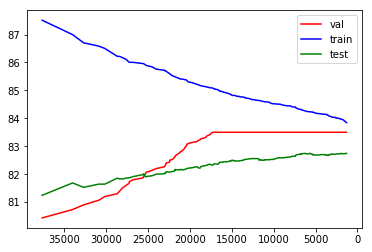

In [186]:
import matplotlib.pyplot as plt

lists = sorted(track.items()) # sorted by key, return a list of tuples
lists2 = sorted(track_train.items()) # sorted by key, return a list of tuples
lists3 = sorted(track_test.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
x1, y1 = zip(*lists2) # unpack a list of pairs into two tuples
x2, y2 = zip(*lists3) # unpack a list of pairs into two tuples


plt.gca().invert_xaxis()
plt.plot(x, y, 'r', label='val')
plt.plot(x1, y1, 'b', label = 'train')
plt.plot(x2, y2, 'g', label='test')
plt.legend()
plt.show()

In [ ]:
result = [[]]*len(validd)
correct=0
wrong = 0
for i in range(len(validd)):
    result[i]=Test(validd[i], root)
    if (result[i]==labelvalid[i]):
        correct+=1
    else:
        wrong+=1
print("accuracy:", correct, wrong, correct/(wrong+correct))

In [ ]:
#majority classifier accuracy
p=0
n=0
for i in range(len(traind)):
    if (labeld[i]==1):
            p+=1
    else:
            n+=1
print(p, n)



In [ ]:
correct=0
for i in range(len(traind)):
    if (labeld[i]==0):
        correct+=1
print(correct/len(traind)*100)

In [ ]:
push = [1,2,3,4]
pull = list(push)
pull.append(5)
print(push)
print(pull)

In [ ]:
p = [[]]*2
# p[0].append(5)
# p[1].append(6)
# p[1].append(7)
# print(p[0])
#p[0]=[1,2,3]

p[0].append(4)
print(p)

In [ ]:
a = []
push = [-1,-2,-3]
for i in range(3):
    pull=list(push)
    pull.append(i)
    a.append(pull)
print(a)

In [ ]:
min(dict, key=dict.get)

In [ ]:
dict(4,300)

In [ ]:
P = [[]]*5
P[1]=2
P[2]=5
P[3]=-2
P[4]=4
P[0]=6



In [ ]:
u = {}
u[1]=5
print(u)

In [ ]:
q = [[]]*5
for i in range(5):
    q[i] = []
q[3]=6
print(q)